In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
train_data = datasets.MNIST(
    root="data", train=True, transform=ToTensor(), download=True
)

test_data = datasets.MNIST(
    root="data", train=False, transform=ToTensor(), download=True
)

In [3]:
print(f"Size of the test data is {test_data.data.shape}")
print(f"Size of the test data is {train_data.data.shape}")

Size of the test data is torch.Size([10000, 28, 28])
Size of the test data is torch.Size([60000, 28, 28])


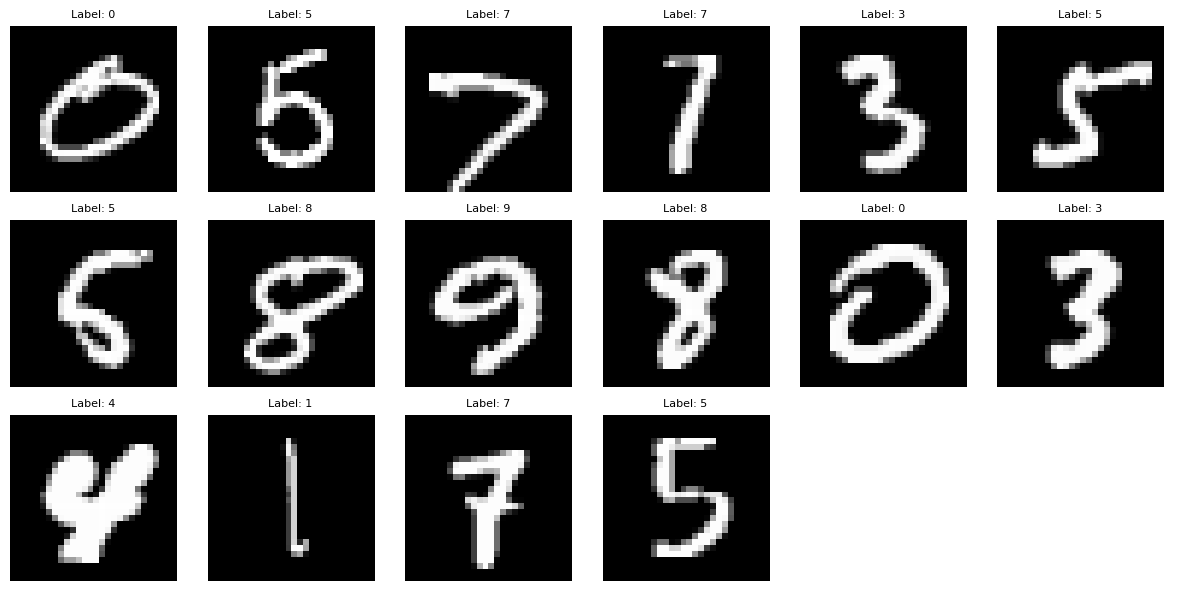

In [4]:
import random as rn
import matplotlib.pyplot as plt
import math


def visualize_random_images(dataset, num_images=10, images_per_row=5) -> None:
    """
    Displays a set of random images from the dataset in a grid format.

    Parameters:
    dataset (torch.utils.data.Dataset): The dataset to sample images from.
    num_images (int): The total number of images to display (default: 10).
    images_per_row (int): Number of images per row in the grid (default: 5).

    Returns:
    None
    """

    dataset_size = len(dataset)
    random_idx = [rn.randint(0, dataset_size - 1) for _ in range(num_images)]

    # calculating the needed number of rows
    num_rows = math.ceil(num_images / images_per_row)

    fig, axes = plt.subplots(
        num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2)
    )

    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, idx in enumerate(random_idx):
        data, target = dataset[idx]
        image = data.squeeze().numpy()  # Convert tensor to numpy format

        # Display image
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(f"Label: {target}", fontsize=8)
        axes[i].axis("off")

    # Hide any unused subplot areas
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


visualize_random_images(train_data, num_images=16, images_per_row=6)

In [5]:
from torch.utils.data import DataLoader

loaders = {
    "train": DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    "test": DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),
}

print(loaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x78abc7f70d70>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x78abc7bfdbd0>}


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(
            1, 10, kernel_size=5
        )  # Conv layer 1: 1 input channel → 10 output channels
        self.conv2 = nn.Conv2d(
            10, 20, kernel_size=5
        )  # Conv layer 2: 10 input channels → 20 output channels
        self.conv2_drop = nn.Dropout2d()  # Dropout layer to reduce overfitting
        self.fc1 = nn.Linear(
            320, 50
        )  # Fully connected layer: 320 input → 50 output neurons
        self.fc2 = nn.Linear(
            50, 10
        )  # Fully connected layer: 50 input → 10 output (10 classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # Conv1 → ReLU → Max Pooling
        x = F.relu(
            F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)
        )  # Conv2 → Dropout → ReLU → Max Pooling
        x = x.view(-1, 320)  # Flatten feature maps into a 1D vector
        x = F.relu(self.fc1(x))  # Fully Connected Layer 1 + ReLU
        x = F.dropout(x, training=self.training)  # Dropout applied before final layer
        x = self.fc2(x)  # Fully Connected Layer 2 (final output layer)

        return F.softmax(x) 

| **Layer**                          | **Operation**     | **Shape Transformation** (for MNIST: `(1, 28, 28)`) |
|-------------------------------------|------------------|-----------------------------------------------|
| **Conv2D (1 → 10, 5×5 kernel)**     | Convolution      | `(1, 28, 28) → (10, 24, 24)`                 |
| **Max Pooling (2×2)**               | Downsampling     | `(10, 24, 24) → (10, 12, 12)`                |
| **Conv2D (10 → 20, 5×5 kernel)**    | Convolution      | `(10, 12, 12) → (20, 8, 8)`                  |
| **Dropout**                         | Regularization   | No shape change                              |
| **Max Pooling (2×2)**               | Downsampling     | `(20, 8, 8) → (20, 4, 4)`                    |
| **Flatten**                         | Reshape          | `(20, 4, 4) → (320,)`                        |
| **Fully Connected (320 → 50)**      | Dense Layer      | `(320,) → (50,)`                             |
| **Dropout**                         | Regularization   | No shape change                              |
| **Fully Connected (50 → 10)**       | Output Layer     | `(50,) → (10,)`                              |

First Convolutional layer applies 10 convolution filters of size $5\times 5$ to the input image. As an input it has a one grayscale image. Each of the 10 filters creates a separate feature map, reducing dimensions from 28×28 → 24×24 due to the 5×5 kernel (no padding). Basically, first convolutional layer detects simple features like edges and corners, that is why no sharp decrease in shape of image. 

First Max Pooling takes the maximum value from each $2\times 2$ region(downsampling). Generally, after max pooling the size is reduced by half. In this stage, we are reducing computation, are extracting dominant features and are preventing overfitting. 

Second Convolutional Layer applies **20** convolutional layers of size $5\times 5$ to the previous feature maps. It extracts more complex features. 

Dropout randomly drops connections during training to prevent overfitting. No impact on shape. It just affects networking learning, by helping with generalization and reducing dependency on specific neurons. 

Second Max Pooling do the same actions as First. Further reduces spatial size and focuses on high-level features.

Flatten is used to transform `(20, 4, 4)` feature maps into a flat vector `(320, `. 

First Fully Connected Layer applies a linear transformation on a flat vector, thus transofming its shape to `(50, )`. 

Again Dropout. 

Final classification layer. Outputs **10** values, each representing a class.

---

softmax. i am currently learning it. 

---

# Training The Model

We check whether `cuda` is available. If not, we will move the model to `cpu`

In [7]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

print(f"The selected device is: {device}")

The selected device is: cpu


In [8]:
import torch.nn as nn
import torch.optim as optim

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)} / {len(loaders['train'].dataset)} "
                f"({100. * batch_idx / len(loaders['train']):.0f}%)]\tLoss: {loss.item():.6f}"
            )


def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders["test"].dataset)
    print(
        f"\nTest set: Average Loss: {test_loss:.4f}, Accuracy: {correct / len(loaders['test'].dataset):.4f} "
        f"({100. * correct / len(loaders['test'].dataset):.0f}%)\n"
    )

In [9]:
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0 / 60000 (0%)]	Loss: 2.304184
Train Epoch: 1 [2000 / 60000 (3%)]	Loss: 2.281881
Train Epoch: 1 [4000 / 60000 (7%)]	Loss: 2.167171
Train Epoch: 1 [6000 / 60000 (10%)]	Loss: 1.995172
Train Epoch: 1 [8000 / 60000 (13%)]	Loss: 1.902930
Train Epoch: 1 [10000 / 60000 (17%)]	Loss: 1.840499
Train Epoch: 1 [12000 / 60000 (20%)]	Loss: 1.866102
Train Epoch: 1 [14000 / 60000 (23%)]	Loss: 1.857007
Train Epoch: 1 [16000 / 60000 (27%)]	Loss: 1.855629
Train Epoch: 1 [18000 / 60000 (30%)]	Loss: 1.720216
Train Epoch: 1 [20000 / 60000 (33%)]	Loss: 1.792027
Train Epoch: 1 [22000 / 60000 (37%)]	Loss: 1.717844
Train Epoch: 1 [24000 / 60000 (40%)]	Loss: 1.715380
Train Epoch: 1 [26000 / 60000 (43%)]	Loss: 1.745071
Train Epoch: 1 [28000 / 60000 (47%)]	Loss: 1.669278
Train Epoch: 1 [30000 / 60000 (50%)]	Loss: 1.711242
Train Epoch: 1 [32000 / 60000 (53%)]	Loss: 1.727169
Train Epoch: 1 [34000 / 60000 (57%)]	Loss: 1.752569
Train Epoch: 1 [36000 / 60000 (60%)]	Loss: 1.639432
Train Epoch: 1 [38000 /

# Evaluating the model Performance. Displaying instances.

In [10]:
import random as rn
import matplotlib.pyplot as plt
import math

model.eval()


def test_it(num_of_images: int) -> None:
    """Test the model on a random set of images and display predictions in a grid."""
    indices = [rn.randint(0, len(test_data) - 1) for _ in range(num_of_images)]
    
    images_per_row = 5  # Number of images in each row
    num_rows = math.ceil(num_of_images / images_per_row)  # Calculate required rows

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))

    # Flatten axes array if there's more than one row
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, idx in enumerate(indices):
        data, target = test_data[idx]
        data = data.unsqueeze(0).to(device)

        output = model(data)
        prediction = output.argmax(dim=1).item()

        print(f'Image {idx}: Prediction={prediction}, Actual={target}')

        image = data.squeeze().cpu().numpy()

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Pred: {prediction}', fontsize=8)
        axes[i].axis('off')

    # Hide any unused subplots (if total images aren't exactly a multiple of images_per_row)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Image 5573: Prediction=3, Actual=3
Image 591: Prediction=2, Actual=8
Image 2223: Prediction=4, Actual=4
Image 5957: Prediction=5, Actual=5
Image 6159: Prediction=1, Actual=1
Image 9262: Prediction=7, Actual=7
Image 5340: Prediction=2, Actual=2
Image 8175: Prediction=7, Actual=7
Image 9714: Prediction=0, Actual=0
Image 1954: Prediction=5, Actual=5
Image 5946: Prediction=4, Actual=4
Image 4231: Prediction=8, Actual=8
Image 1963: Prediction=4, Actual=4
Image 4325: Prediction=9, Actual=9
Image 8198: Prediction=4, Actual=2
Image 5331: Prediction=6, Actual=1
Image 9513: Prediction=5, Actual=5
Image 381: Prediction=3, Actual=3
Image 5976: Prediction=8, Actual=8
Image 6226: Prediction=3, Actual=3


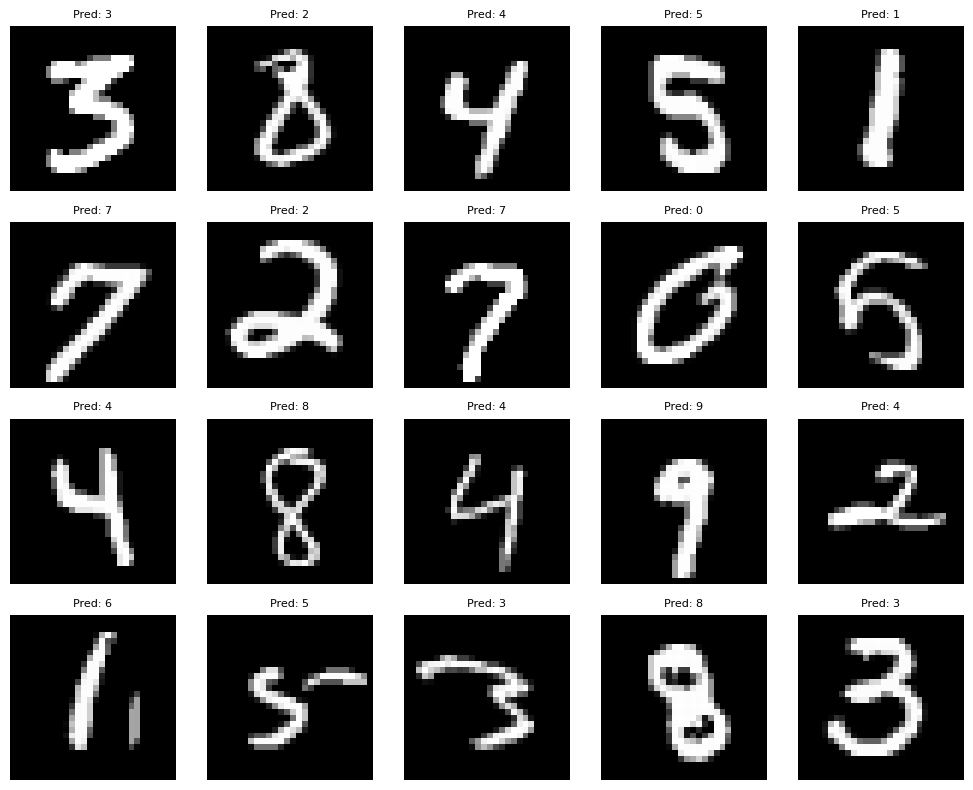

In [11]:
test_it(20)

# GUI

In [12]:
import tkinter as tk
from tkinter import Canvas, Button
import numpy as np
from PIL import Image, ImageOps, ImageGrab
import torch

# Function to preprocess the drawn image
def preprocess_image(image):
    # Resize to 28x28 pixels
    image = image.resize((28, 28))
    # Convert to grayscale
    image = ImageOps.grayscale(image)
    # Convert to numpy array
    image = np.array(image)
    # Normalize pixel values to [0, 1]
    image = image / 255.0
    # Invert colors (MNIST digits are white on black)
    image = 1 - image
    # Convert to PyTorch tensor and add batch and channel dimensions
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return image

# Function to predict the drawn digit
def predict_digit():

    model.eval()
    
    # Get the canvas and save it as an image
    x = root.winfo_rootx() + canvas.winfo_x()
    y = root.winfo_rooty() + canvas.winfo_y()
    x1 = x + canvas.winfo_width()
    y1 = y + canvas.winfo_height()
    img = ImageGrab.grab((x, y, x1, y1))
    # Preprocess the image
    img_processed = preprocess_image(img)
    # Predict the digit using your PyTorch model
    with torch.no_grad():
        output = model(img_processed)
        _, predicted = torch.max(output, 1)
    digit = predicted.item()
    # Display the prediction
    result_label.config(text=f"Predicted Digit: {digit}")

# Function to clear the canvas
def clear_canvas():
    canvas.delete("all")
    result_label.config(text="Predicted Digit: ")

# Create the main window
root = tk.Tk()
root.title("MNIST Digit Predictor (PyTorch)")

# Create a canvas for drawing
canvas = Canvas(root, width=28, height=28, bg="white")
canvas.pack()

# Create a button to predict the digit
predict_button = Button(root, text="Predict", command=predict_digit)
predict_button.pack(side=tk.LEFT)

# Create a button to clear the canvas
clear_button = Button(root, text="Clear", command=clear_canvas)
clear_button.pack(side=tk.RIGHT)

# Label to display the prediction result
result_label = tk.Label(root, text="Predicted Digit: ", font=("Arial", 16))
result_label.pack()

# Bind mouse events to draw on the canvas
def paint(event):
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
    canvas.create_oval(x1, y1, x2, y2, fill="black", outline="black")

canvas.bind("<B1-Motion>", paint)

# Run the application
root.mainloop()

# Resources

1. https://www.youtube.com/watch?v=vBlO87ZAiiw. NeuralNine. PyTorch Project: Handwritten Digit Recognition.
2. https://github.com/billy-enrizky/Pytorch-Handwritten-Digit-Recognition.
3. https://matplotlib.org/stable/tutorials/images.html
4. https://realpython.com/python-gui-tkinter/#building-your-first-python-gui-application-with-tkinter